In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Flatten, Dropout, Conv2D
import os
from sklearn.model_selection import train_test_split
import collections
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO
from IPython.display import FileLink
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = "/content/drive/MyDrive/DATASET/train"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [4]:
def prep_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

In [5]:
def get_dataset_path(base_path):
    classes = sorted(os.listdir(base_path))
    file_paths = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(base_path, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(i)

    return file_paths, labels, classes

In [6]:
file_paths, labels, class_names = get_dataset_path(base_path)

print(f"Found {len(file_paths)} images in {len(class_names)} classes.")

Found 7014 images in 6 classes.



Distribusi Kelas:
         Jumlah Sample
Kelas                 
Kertas            1807
Plastik           1257
Logam             1210
Kaca              1110
Residu            1006
Kardus             624

Total Sample: 7014


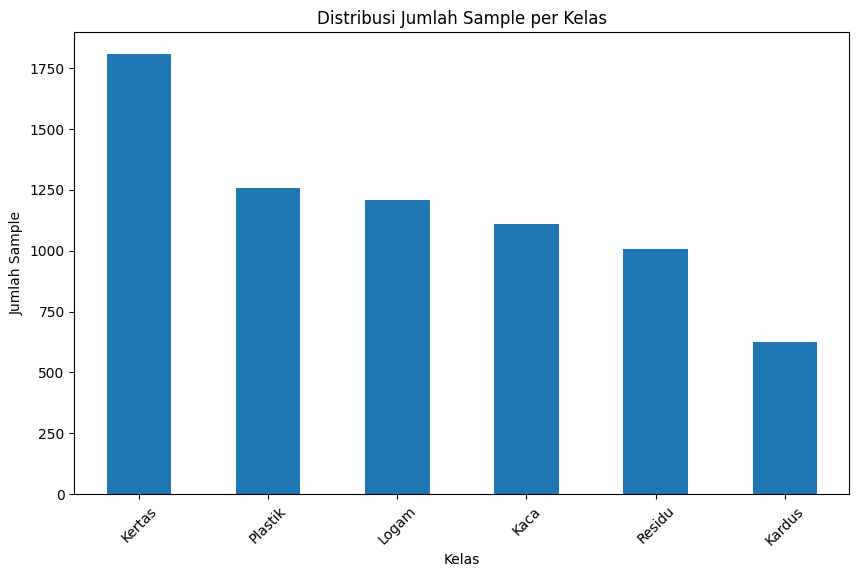

In [7]:
from pathlib import Path
import pandas as pd



# Hitung jumlah file per kelas
main_folder_path = Path(base_path)
all_folders = [d for d in main_folder_path.glob('*/') if d.is_dir()]  # Hanya subfolder langsung

data = []
for folder in all_folders:
    folder_name = folder.name
    # Hitung hanya file gambar (modifikasi pattern sesuai kebutuhan)
    file_count = len([
        f for f in folder.glob('*')
        if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png']
    ])
    data.append({'Kelas': folder_name, 'Jumlah Sample': file_count})

# Buat DataFrame dan tampilkan
count_df = pd.DataFrame(data).sort_values('Jumlah Sample', ascending=False)
count_df = count_df.set_index('Kelas')
print("\nDistribusi Kelas:")
print(count_df)
print(f"\nTotal Sample: {count_df['Jumlah Sample'].sum()}")

# Visualisasi (opsional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
count_df['Jumlah Sample'].plot(kind='bar')
plt.title('Distribusi Jumlah Sample per Kelas')
plt.ylabel('Jumlah Sample')
plt.xticks(rotation=45)
plt.show()

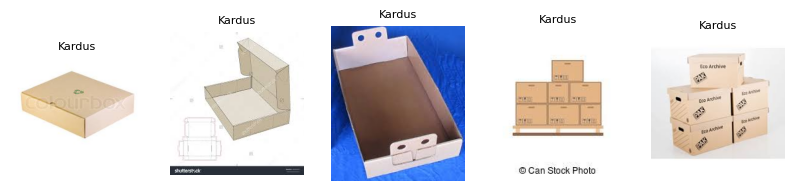

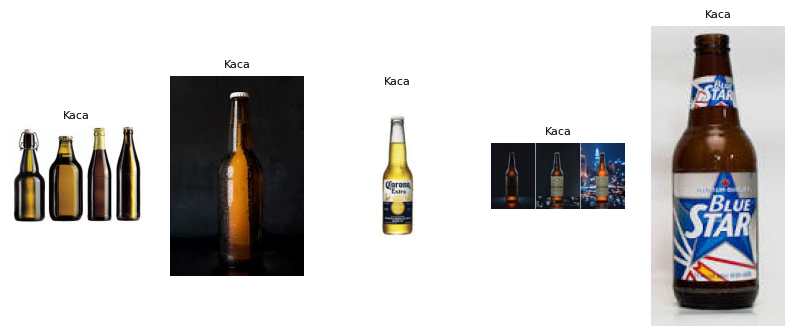

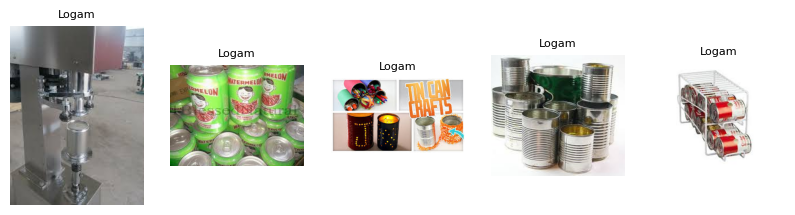

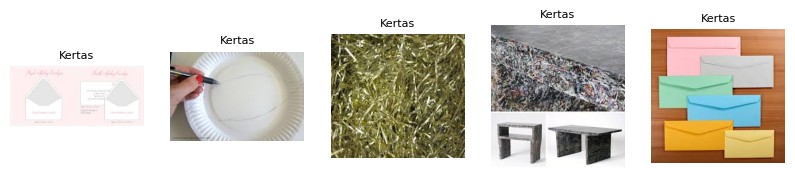

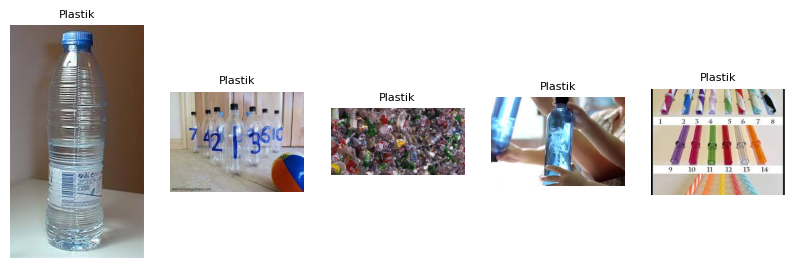

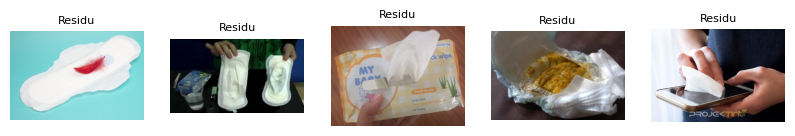

In [8]:
def plot_images(item_dir):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
    plt.figure(figsize=(10, 10))
    for image_id, image_path in enumerate(item_files):
        plt.subplot(1, 5, image_id+1)
        img = plt.imread(image_path)
        plt.axis('off')
        plt.imshow(img)
        plt.title(os.path.basename(item_dir), fontsize=8)

categories = ["Kardus", "Kaca", "Logam", "Kertas", "Plastik", "Residu"]
for category in categories:
    plot_images(os.path.join(base_path, category))

In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

In [10]:
def create_dataset(file_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(prep_image, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size = 1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
train_dataset = create_dataset(train_paths, train_labels)
test_dataset = create_dataset(test_paths, test_labels)
val_dataset = create_dataset(val_paths, val_labels)

In [12]:
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    return img, label

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
def build_model(num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [14]:
num_classes = len(class_names)
model = build_model(num_classes)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 2,388,614 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 2207s 11s/step - accuracy: 0.2661 - loss: 2.0365 - val_accuracy: 0.5350 - val_loss: 1.2987 - learning_rate: 1.0000e-05
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1602s 9s/step - accuracy: 0.4715 - loss: 1.3724 - val_accuracy: 0.6961 - val_loss: 0.9344 - learning_rate: 1.0000e-05
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1642s 9s/step - accuracy: 0.6270 - loss: 1.0303 - val_accuracy: 0.7718 - val_loss: 0.7085 - learning_rate: 1.0000e-05
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1673s 9s/step - accuracy: 0.7064 - loss: 0.8383 - val_accuracy: 0.8103 - val_loss: 0.5749 - learning_rate: 1.0000e-05
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1557s 9s/step - accuracy: 0.7629 - loss: 0.6910 - val_accuracy: 0.8388 - val_loss: 0.4932 - learning_rate: 1.0000e-05
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1527s 9s/step - accuracy: 0.7802 - loss: 0.6219 - val_accuracy: 0.8531 - val_loss: 0.4359 - learning_rate: 1.0000e-05
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1560s 9s/st

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9202 - loss: 0.2904
Test Accuracy: 92.17%


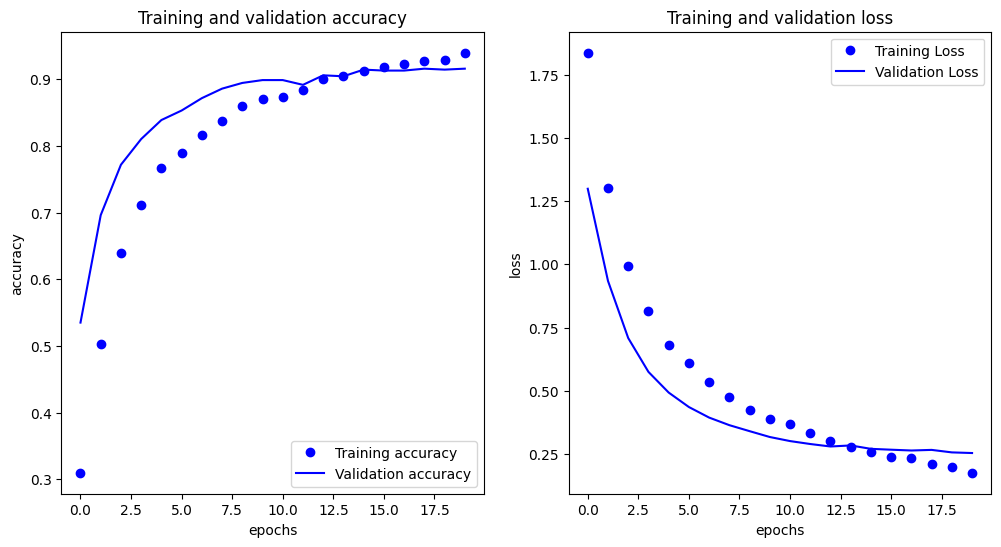

In [19]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [20]:
import keras.utils as ku

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Probability: 0.98378754
Classified: Plastik 



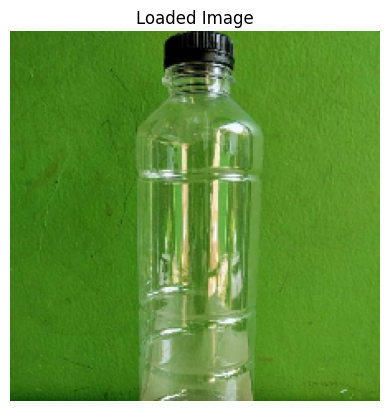

In [22]:


# Dictionary untuk klasifikasi
number_to_class = {
    0: 'Besi',
    1: 'Kaca',
    2: 'Kardus',
    3: 'Kertas',
    4: 'Plastik',
    5: 'Other'
}

# Load dan preprocess gambar
test_img = 'Image_1.jpg'
img = ku.load_img(test_img, target_size=(224, 224))
img = ku.img_to_array(img, dtype=np.uint8)
img = np.array(img) / 255.0

# Prediksi dengan model
prediction = model.predict(img[np.newaxis, ...])

# Hasil klasifikasi
print("Probability:", np.max(prediction[0], axis=-1))
predicted_class = number_to_class[np.argmax(prediction[0], axis=-1)]
print("Classified:", predicted_class, '\n')

# Tampilkan gambar
plt.axis('off')
plt.imshow(img.squeeze())
plt.title("Loaded Image")
plt.show()


In [34]:
import os
import shutil
import random

# Path dataset utama
dataset_path = "/content/drive/MyDrive/DATASET"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")


if not os.path.exists(train_path):
    raise FileNotFoundError(f"Path '{train_path}' tidak ditemukan. Periksa lokasi dataset!")


if not os.path.exists(test_path):
    os.makedirs(test_path)


test_ratio = 0.5  # 50% dari total data


for class_name in os.listdir(train_path):
    class_train_path = os.path.join(train_path, class_name)
    class_test_path = os.path.join(test_path, class_name)


    if not os.path.exists(class_test_path):
        os.makedirs(class_test_path)


    images = [img for img in os.listdir(class_train_path) if img.endswith(('.jpg', '.png', '.jpeg'))]


    if len(images) == 0:
        print(f"Peringatan: Tidak ada gambar di '{class_train_path}', lewati kelas ini.")
        continue

    num_test_samples = int(len(images) * test_ratio)

    # Pilih gambar secara acak
    test_images = random.sample(images, num_test_samples)

    # Pindahkan gambar ke folder test
    for img in test_images:
        src_path = os.path.join(class_train_path, img)
        dest_path = os.path.join(class_test_path, img)

        shutil.copy2(src_path, dest_path)

print("Dataset uji berhasil dibuat!")



Dataset uji berhasil dibuat!


In [35]:
import os

test_path = "/content/drive/MyDrive/DATASET/test"

# Periksa jumlah gambar per kelas
for class_name in os.listdir(test_path):
    class_test_path = os.path.join(test_path, class_name)
    num_images = len(os.listdir(class_test_path))
    print(f"Kelas {class_name}: {num_images} gambar")


Kelas Kaca: 555 gambar
Kelas Kardus: 312 gambar
Kelas Kertas: 903 gambar
Kelas Logam: 605 gambar
Kelas Plastik: 628 gambar
Kelas Residu: 501 gambar


Found 3504 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 172s 782ms/step


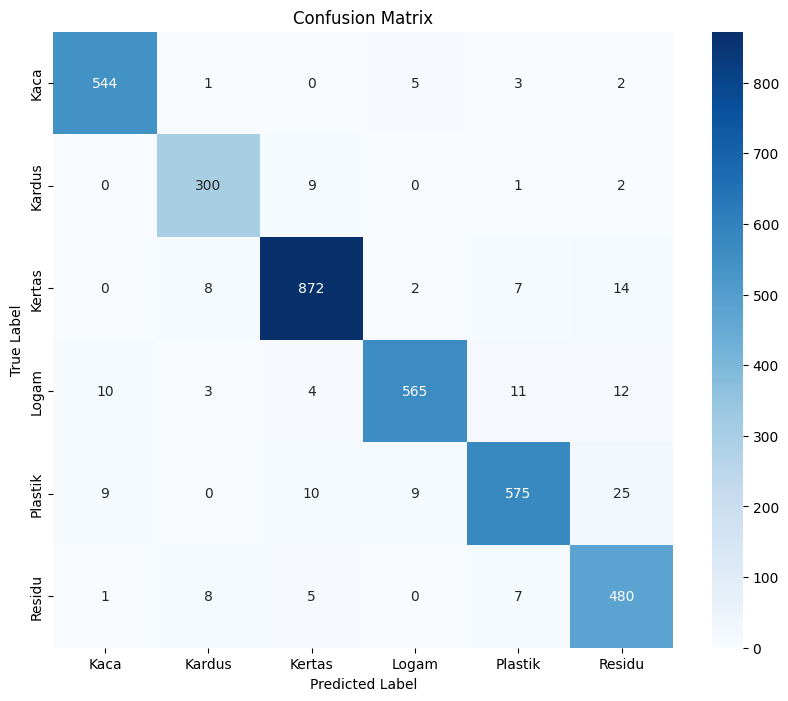


Classification Report:
              precision    recall  f1-score   support

        Kaca       0.96      0.98      0.97       555
      Kardus       0.94      0.96      0.95       312
      Kertas       0.97      0.97      0.97       903
       Logam       0.97      0.93      0.95       605
     Plastik       0.95      0.92      0.93       628
      Residu       0.90      0.96      0.93       501

    accuracy                           0.95      3504
   macro avg       0.95      0.95      0.95      3504
weighted avg       0.95      0.95      0.95      3504



In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Buat ImageDataGenerator untuk dataset uji
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Prediksi model pada dataset uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Ambil label sebenarnya
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Buat Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


In [37]:
import os
import shutil
import numpy as np

# Path dataset uji
test_path = "/content/drive/MyDrive/DATASET/test"
valid_path = "/content/drive/MyDrive/DATASET/valid"

# Buat folder valid jika belum ada
if not os.path.exists(valid_path):
    os.makedirs(valid_path)

# Buat subfolder untuk setiap kelas dalam folder valid
for class_name in test_generator.class_indices.keys():
    class_dir = os.path.join(valid_path, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Dapatkan path file gambar dalam test set
file_paths = test_generator.filepaths

# Pindahkan gambar yang diklasifikasikan dengan benar ke folder valid
for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred_classes)):
    if true_label == pred_label:  # Jika prediksi benar
        src = file_paths[i]  # Path gambar asli
        dst = os.path.join(valid_path, class_labels[true_label], os.path.basename(src))  # Path tujuan

        shutil.move(src, dst)  # Pindahkan file ke folder valid

print("Gambar valid telah dipindahkan ke folder:", valid_path)



Gambar valid telah dipindahkan ke folder: /content/drive/MyDrive/DATASET/valid


In [38]:
import tensorflow as tf
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Tentukan folder tujuan di Google Drive
save_dir = '/content/drive/MyDrive/Colab Notebooks/Saved Models'  # Ganti dengan folder tujuan Anda
os.makedirs(save_dir, exist_ok=True)  # Buat folder jika belum ada

# 3. Simpan model Keras (.keras)
keras_model_path = os.path.join(save_dir, 'my_model.keras')
model.save(keras_model_path)  # Ganti 'model' dengan model Anda

# 4. Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 5. Simpan model TFLite (.tflite)
tflite_model_path = os.path.join(save_dir, 'GarbageClassModel.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model Keras disimpan di: {keras_model_path}")
print(f"Model TFLite disimpan di: {tflite_model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved artifact at '/tmp/tmpue7w6cz7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139016357078288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357076368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357079632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357079056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357078480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357075792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357077712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357079440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139016357080208: Tens